In [52]:
import sys
sys.path.append('..')
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

## Load and Clean Data

In [53]:
data = pd.read_csv('../../data/namdinh.csv').fillna(0)

/Users/msanch35/Documents/6.871/mlhc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3229: DtypeWarning: Columns (27,33,61,65,69,71,81,82,103,104,106,107,113,114,116,117,120,132,133,134) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [54]:
drop = ['border', 
         'covid', 
         'fibrosis', 
         'pulmonary_scar', 
         'lung_opacity', 
         'airspace_opacity', 
         'other_findings', 
         'enlarged_cardiomediastinum']

### Merge Eqiuvalent Findings


In [55]:
data['opacity'] = data[['lung_opacity', 'airspace_opacity']].max(axis=1)
data['ai_opacity'] = data[['ai_lung_opacity', 'ai_airspace_opacity']].max(axis=1)

data['lung_scar'] = data[['fibrosis', 'pulmonary_scar']].max(axis=1)
data['ai_lung_scar'] = data[['ai_fibrosis', 'ai_pulmonary_scar']].max(axis=1)

### Set Clinically Significant Findings

In [56]:
findings = []
for i in list(data.columns):
    if 'ai_' == i[0:3]:
        add = True
        for j in drop:
            if j in i:
                add=False
        if add:    
            findings.append(i[3::])
            
sig_findings = [
    'cardiomegaly',
    'cavitation',
    'consolidation',
    'edema',
    #'enlarged_cardiomediastinum',
    'fracture',
    'lung_lesion',
    'opacity',
    'mass',
    'mass_nodule',
    'nodule',
    'pleural_effusion',
    'pneumonia',
    'pneumothorax',
    'tuberculosis',
    'widening_mediastinum'
]
non_sig_findings = [i for i in findings if i not in sig_findings]
non_sig_findings

['no_finding', 'atelectasis', 'pleural_other', 'medical_device', 'lung_scar']

In [57]:
finding_tab = pd.DataFrame(columns = ['Finding', 
                        'Prevalence', 
                        'Disagreement Rate', 
                        'Diagnostic TPR',
                        'Diagnostic FPR',
                       ])
finding_tab['Finding'] = findings

## Compute Average Prevalence Over All Findings Together and Seperately

In [38]:
avg_p_find = 0
for i in range(len(findings)):
    p_find = len(data[data[findings[i]] ==1])
    finding_tab.at[i, 'Prevalence'] = p_find / len(data)
    avg_p_find += p_find
avg_p_find /= len(findings) * len(data)
print(avg_p_find*100)

7.677169079383102


## Compute Average Prevalence Of Disagreement in All Findings Together and Seperately

In [37]:
avg_p_dis = 0
dis_list = []
for i in range(len(findings)):
    p_dis = len(data[data[findings[i]] != data['ai_'+findings[i]]])
    finding_tab.at[i, 'Disagreement Rate'] = p_dis / len(data)
    avg_p_dis += p_dis
avg_p_dis /= len(findings) * len(data)
print('Mean', avg_p_dis*100)
print('Median', np.median(finding_tab['Disagreement Rate'])*100)
print('IQR', np.quantile(finding_tab['Disagreement Rate'], 0.25)*100, np.quantile(finding_tab['Disagreement Rate'], 0.75)*100)

Mean 6.784463998486139
Median 2.540448481407891
IQR 1.251300974548207 10.514239757782192


In [36]:
dis_list = []
for i in range(len(findings)):
    dis_list.append(data[findings[i]] != data['ai_'+findings[i]])
dis_arr = np.array(dis_list).flatten()
print('pop mean', dis_arr.mean())
print('pop var', dis_arr.std())

pop mean 0.06784463998486139
pop var 0.25147911406354595


## Compute Average True Positive and False Positive Rates of the Diagnostic Model in Each Finding Seperately and Overall

In [39]:
avg_TPR_f = 0
den = 0
for i in range(len(findings)):
    if len(data[data[findings[i]]==1]) > -1:#0:
        TPR_f = len(data[(data[findings[i]] == data['ai_'+findings[i]]) & (data[findings[i]]==1)])
        den_curr = len(data[data[findings[i]]==1])
        finding_tab.at[i, 'Diagnostic TPR'] = TPR_f / den_curr
        avg_TPR_f += TPR_f
        den +=  den_curr
avg_TPR_f /= den
print(avg_TPR_f*100)

80.12077890066551


In [40]:
avg_FPR_f = 0
den = 0
for i in range(len(findings)):
    if len(data[data[findings[i]]==1]) > -1:#0:
        FPR_f = len(data[(data[findings[i]] != data['ai_'+findings[i]]) & (data[findings[i]]==0)])
        den_curr = len(data[data[findings[i]]==0])
        finding_tab.at[i, 'Diagnostic FPR'] = FPR_f / den_curr
        avg_FPR_f += len(data[(data[findings[i]] != data['ai_'+findings[i]]) & (data[findings[i]]==0)])
        den += len(data[data[findings[i]]==0])
avg_FPR_f /= den
print(avg_FPR_f*100)

5.695560383700911


## Split Data on Prevalence, Disagreement Rate, and Diagnostic TPR and FPR

In [41]:
finding_tab

,Finding,Prevalence,Disagreement Rate,Diagnostic TPR,Diagnostic FPR
0,no_finding,0.389157,0.253288,0.549964,0.127943
1,cardiomegaly,0.021951,0.018166,0.978448,0.018090
2,fracture,0.022046,0.015990,0.914163,0.014416
3,lung_lesion,0.007002,0.005204,0.851351,0.004192
4,pleural_effusion,0.052985,0.026398,0.832143,0.018483
5,pneumothorax,0.012773,0.012300,0.933333,0.011597
6,atelectasis,0.055445,0.071530,0.831058,0.065812
7,consolidation,0.015990,0.023559,0.976331,0.023558
8,pneumonia,0.000946,0.000946,0.000000,0.000000
9,edema,0.000757,0.000757,0.625000,0.000473


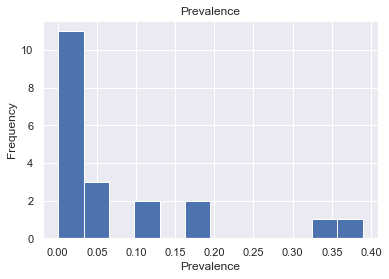

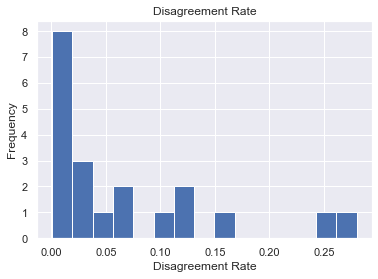

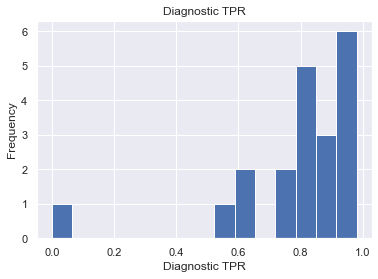

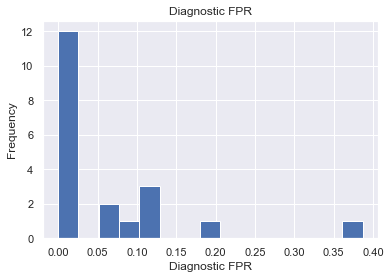

In [42]:
plt.hist(finding_tab['Prevalence'], bins=12)
plt.title('Prevalence')
plt.xlabel('Prevalence')
plt.ylabel('Frequency')
plt.show()
plt.hist(finding_tab['Disagreement Rate'], bins=15)
plt.title('Disagreement Rate')
plt.xlabel('Disagreement Rate')
plt.ylabel('Frequency')
plt.show()
plt.hist(finding_tab['Diagnostic TPR'], bins=15)
plt.title('Diagnostic TPR')
plt.xlabel('Diagnostic TPR')
plt.ylabel('Frequency')
plt.show()
plt.hist(finding_tab['Diagnostic FPR'], bins=15)
plt.title('Diagnostic FPR')
plt.xlabel('Diagnostic FPR')
plt.ylabel('Frequency')
plt.show()

In [43]:
t1 = pd.DataFrame(columns = ['Variable','Number of Findings', 'Percentage of Findings'])
t1['Variable'] = ['Prevalence 0-10%',
                 'Prevalence 10-20%',
                 'Prevalence 30-40%',
                 'Disagreement Rate 0-10%', 
                 'Disagreement Rate 10-20%',
                 'Disagreement Rate 20-30%',
                 'Diagnostic TPR 0.5-0.7',
                 'Diagnostic TPR >0.7',
                 'Diagnostic FPR 0.05-0.15',
                 'Diagnostic FPR 0.15-0.2',
                 'Diagnostic FPR 0.35-0.4',
                 #'Doctor 1', 
                 #'Radiologists 2 and 3', 
                 #'Radiologist Not Reported', 
                ]
t1 = t1.set_index('Variable')

In [44]:
t1.at['Prevalence 0-10%','Percentage of Findings'] = len(finding_tab[
                                            finding_tab['Prevalence'] < .1]) / len(finding_tab)
t1.at['Prevalence 10-20%','Percentage of Findings'] = len(finding_tab[
                                            (finding_tab['Prevalence'] >= .1) & (finding_tab['Prevalence'] < .2)
                                        ]) / len(finding_tab)
t1.at['Prevalence 30-40%','Percentage of Findings'] = len(finding_tab[
                                            (finding_tab['Prevalence'] >= .3) & (finding_tab['Prevalence'] < .4)
                                        ]) / len(finding_tab)
t1.at['Disagreement Rate 0-10%','Percentage of Findings'] = len(finding_tab[
                                            (finding_tab['Disagreement Rate'] >= .0) & (finding_tab['Disagreement Rate'] < .1)
                                        ]) / len(finding_tab)
t1.at['Disagreement Rate 10-20%','Percentage of Findings'] = len(finding_tab[
                                            (finding_tab['Disagreement Rate'] >= .1) & (finding_tab['Disagreement Rate'] < .2)
                                        ]) / len(finding_tab)
t1.at['Disagreement Rate 20-30%','Percentage of Findings'] = len(finding_tab[
                                            (finding_tab['Disagreement Rate'] >= .2) & (finding_tab['Disagreement Rate'] < .3)
                                        ]) / len(finding_tab)
t1.at['Diagnostic TPR 0.5-0.7','Percentage of Findings'] = len(finding_tab[
                                            (finding_tab['Diagnostic TPR'] >= .5) & (finding_tab['Diagnostic TPR'] < .7)
                                        ]) / len(finding_tab)
t1.at['Diagnostic TPR >0.7','Percentage of Findings'] = len(finding_tab[
                                            (finding_tab['Diagnostic TPR'] >= .7)]) / len(finding_tab)
t1.at['Diagnostic FPR 0.05-0.15','Percentage of Findings'] = len(finding_tab[
                                            (finding_tab['Diagnostic FPR'] >= .05) & (finding_tab['Diagnostic FPR'] < .15)
                                        ]) / len(finding_tab)
t1.at['Diagnostic FPR 0.15-0.2','Percentage of Findings'] = len(finding_tab[
                                            (finding_tab['Diagnostic FPR'] >= .15) & (finding_tab['Diagnostic FPR'] < .2)
                                        ]) / len(finding_tab)
t1.at['Diagnostic FPR 0.35-0.4','Percentage of Findings'] = len(finding_tab[
                                            (finding_tab['Diagnostic FPR'] >= .35) & (finding_tab['Diagnostic FPR'] < .4)
                                        ]) / len(finding_tab)
t1['Number of Findings'] = t1['Percentage of Findings']*len(finding_tab)

In [45]:
t1

,Number of Findings,Percentage of Findings
Variable,,
Prevalence 0-10%,15.0,0.75
Prevalence 10-20%,3.0,0.15
Prevalence 30-40%,2.0,0.10
Disagreement Rate 0-10%,14.0,0.70
Disagreement Rate 10-20%,4.0,0.20
Disagreement Rate 20-30%,2.0,0.10
Diagnostic TPR 0.5-0.7,3.0,0.15
Diagnostic TPR >0.7,16.0,0.80
Diagnostic FPR 0.05-0.15,6.0,0.30


### Produce a Table Describing Findings (Including Class Membership)

In [46]:
for i in range(len(findings)):
    finding_tab['Prevalence 0-10%'] = finding_tab['Prevalence'] < .1
    finding_tab['Prevalence 10-20%'] = (finding_tab['Prevalence'] >= .1) & (finding_tab['Prevalence'] < .2)
    finding_tab['Prevalence 30-40%'] = (finding_tab['Prevalence'] >= .3) & (finding_tab['Prevalence'] < .4)
    finding_tab['Disagreement Rate 0-10%'] = (finding_tab['Disagreement Rate'] >= .0) & (finding_tab['Disagreement Rate'] < .1)
    finding_tab['Disagreement Rate 10-20%'] = (finding_tab['Disagreement Rate'] >= .1) & (finding_tab['Disagreement Rate'] < .2)
    finding_tab['Disagreement Rate 20-30%'] = (finding_tab['Disagreement Rate'] >= .2) & (finding_tab['Disagreement Rate'] < .3)
    finding_tab['Diagnostic TPR 0.5-0.7'] = (finding_tab['Diagnostic TPR'] >= .5) & (finding_tab['Diagnostic TPR'] < .7)
    finding_tab['Diagnostic TPR >0.7'] = (finding_tab['Diagnostic TPR'] >= .7)
    finding_tab['Diagnostic FPR 0.05-0.15'] = (finding_tab['Diagnostic FPR'] >= .05) & (finding_tab['Diagnostic FPR'] < .15)
    finding_tab['Diagnostic FPR 0.15-0.2'] = (finding_tab['Diagnostic FPR'] >= .15) & (finding_tab['Diagnostic FPR'] < .2)
    finding_tab['Diagnostic FPR 0.35-0.4'] = (finding_tab['Diagnostic FPR'] >= .35) & (finding_tab['Diagnostic FPR'] < .4)
    

In [47]:
finding_tab

,Finding,Prevalence,Disagreement Rate,Diagnostic TPR,Diagnostic FPR,Prevalence 0-10%,Prevalence 10-20%,Prevalence 30-40%,Disagreement Rate 0-10%,Disagreement Rate 10-20%,Disagreement Rate 20-30%,Diagnostic TPR 0.5-0.7,Diagnostic TPR >0.7,Diagnostic FPR 0.05-0.15,Diagnostic FPR 0.15-0.2,Diagnostic FPR 0.35-0.4
0,no_finding,0.389157,0.253288,0.549964,0.127943,False,False,True,False,False,True,True,False,True,False,False
1,cardiomegaly,0.021951,0.018166,0.978448,0.018090,True,False,False,True,False,False,False,True,False,False,False
2,fracture,0.022046,0.015990,0.914163,0.014416,True,False,False,True,False,False,False,True,False,False,False
3,lung_lesion,0.007002,0.005204,0.851351,0.004192,True,False,False,True,False,False,False,True,False,False,False
4,pleural_effusion,0.052985,0.026398,0.832143,0.018483,True,False,False,True,False,False,False,True,False,False,False
5,pneumothorax,0.012773,0.012300,0.933333,0.011597,True,False,False,True,False,False,False,True,False,False,False
6,atelectasis,0.055445,0.071530,0.831058,0.065812,True,False,False,True,False,False,False,True,True,False,False
7,consolidation,0.015990,0.023559,0.976331,0.023558,True,False,False,True,False,False,False,True,False,False,False
8,pneumonia,0.000946,0.000946,0.000000,0.000000,True,False,False,True,False,False,False,False,False,False,False
9,edema,0.000757,0.000757,0.625000,0.000473,True,False,False,True,False,False,True,False,False,False,False


### Produce a Smaller Version of the Above Table Without Class Membership

In [48]:
finding_tab.to_csv('../../data/finding_stats.csv')

In [49]:
small_finding_tab = finding_tab[['Finding', 'Prevalence', 'Disagreement Rate', 'Diagnostic TPR', 'Diagnostic FPR']]
small_finding_tab[['Prevalence', 'Disagreement Rate', 'Diagnostic TPR', 'Diagnostic FPR']] = small_finding_tab[['Prevalence', 'Disagreement Rate', 'Diagnostic TPR', 'Diagnostic FPR']].astype(np.float).round(decimals=4)
small_finding_tab

/Users/msanch35/Documents/6.871/mlhc/lib/python3.7/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Finding,Prevalence,Disagreement Rate,Diagnostic TPR,Diagnostic FPR
0,no_finding,0.3892,0.2533,0.5500,0.1279
1,cardiomegaly,0.0220,0.0182,0.9784,0.0181
2,fracture,0.0220,0.0160,0.9142,0.0144
3,lung_lesion,0.0070,0.0052,0.8514,0.0042
4,pleural_effusion,0.0530,0.0264,0.8321,0.0185
5,pneumothorax,0.0128,0.0123,0.9333,0.0116
6,atelectasis,0.0554,0.0715,0.8311,0.0658
7,consolidation,0.0160,0.0236,0.9763,0.0236
8,pneumonia,0.0009,0.0009,0.0000,0.0000
9,edema,0.0008,0.0008,0.6250,0.0005


In [50]:
small_finding_tab.to_csv('../../data/finding_stats_small.csv')

## Miscellaneous Analyses

One doctor produced the majority of the data points.

In [60]:
data[data['doctor'] != 'phamthaiphi1551991@gmail.com']['doctor']

12        huuthu1974bvl@gmail.com
20        huuthu1974bvl@gmail.com
70                              0
71                              0
516    bvp.namdinh@mailinator.com
931    bvp.namdinh@mailinator.com
Name: doctor, dtype: object

In [70]:
1-len(data[data['doctor'] != 'phamthaiphi1551991@gmail.com']['doctor'])/len(data)

0.9994323020153278

Pneumonia is very rare in our patient population (only 10 patients have pneumonia), and the AI model missed all 10 of them. This contributes to the perfect FPR and 0 TPR.

In [80]:
data['ai_pneumonia'].sum(), data['pneumonia'].sum()

(0.0, 10.0)

The vast majority of patients (nearly 7000) have 1 finding present. Around 1000 patients have 0, 2, or 3 findings present, and a negligible amount of patients have 6 or more findings present.

In [64]:
counts = np.unique(data[findings].sum(axis=1), return_counts=True)
print(counts)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([ 945, 6730, 1111,  698,  525,  356,  143,   45,   15,    1]))


/Users/msanch35/Documents/6.871/mlhc/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:>

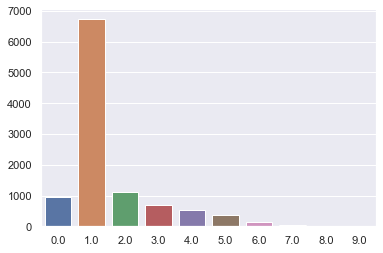

In [68]:
import seaborn as sns
sns.barplot(counts[0], counts[1])

Enlarged Cardiomediastinum is redundant for all samples with the exception of 8.

In [58]:
data[(data['enlarged_cardiomediastinum']==True) & (data['cardiomegaly']==False) & (data['widening_mediastinum']==False)]#['widening_mediastinum'].sum()

,image_id,pid,doctor,date,ai_no_finding,ai_airspace_opacity,ai_cardiomegaly,ai_fracture,ai_lung_lesion,ai_pleural_effusion,...,cov_samplingdate,cov_resultdate,cov_pcrresult,covid_symptoms_complete,doctor_decided_at,doctor_decided_by,opacity,ai_opacity,lung_scar,ai_lung_scar
1942,1.2.392.200046.100.14.881377719262982468842335...,2.021022e+13,phamthaiphi1551991@gmail.com,2021-02-19 02:33:52.254000+00:00,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0,0,0,0.0,1.0,0.0,0.0
2092,1.2.392.200046.100.14.167321983728928046874966...,2.021022e+13,phamthaiphi1551991@gmail.com,2021-02-17 08:38:36.838000+00:00,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0
3038,1.2.392.200046.100.14.337950285907390115168212...,2.021021e+13,phamthaiphi1551991@gmail.com,2021-02-05 07:20:02.791000+00:00,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,F,0,0,0.0,0.0,0.0,0.0
3298,1.2.392.200046.100.14.272666204594855162185774...,2.021020e+13,phamthaiphi1551991@gmail.com,2021-02-04 08:03:04.386000+00:00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,F,0,0,0.0,0.0,0.0,0.0
7953,1.2.392.200046.100.14.537228513906913931001336...,2.020123e+13,phamthaiphi1551991@gmail.com,2020-12-25 07:14:53.402000+00:00,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,2020-12-25 07:14:53.402000+00:00,phamthaiphi1551991@gmail.com,0.0,1.0,0.0,0.0
8433,1.2.392.200046.100.14.537228513906913931001336...,2.020123e+13,phamthaiphi1551991@gmail.com,2020-12-25 07:14:53.402000+00:00,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,2020-12-25 07:14:53.402000+00:00,phamthaiphi1551991@gmail.com,0.0,1.0,0.0,0.0
9802,1.2.392.200046.100.14.449007914044380915960070...,2.021012e+13,phamthaiphi1551991@gmail.com,2021-01-22 01:32:11.255000+00:00,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0
10041,1.2.392.200046.100.14.435953841381033664182198...,2.021013e+13,phamthaiphi1551991@gmail.com,2021-01-25 09:20:08.053000+00:00,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,1.0,1.0,0.0,1.0
